In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
%autoreload 2

import sys,os,glob
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
from ipywidgets import *
import ipywidgets as widgets

from mpl_toolkits.axes_grid1 import make_axes_locatable

## Add own library to path
workdir = os.getcwd()
thismodule = sys.modules[__name__]
moduledir = os.path.join(os.path.dirname(workdir),'src')
functionsdir = os.path.join(os.path.dirname(workdir),'functions')
sys.path.insert(0,moduledir)
sys.path.insert(0,functionsdir)
for includedir in [moduledir,functionsdir]:
    print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                     for x in glob.glob(os.path.join(includedir,'*.py'))])

from conditionalstats import *
from plot1DInvLog import *
from plot2D import *

## Input data dir
inputdir = os.path.join(os.path.dirname(workdir),'input')

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

Own modules available: ['conditionalstats']
Own modules available: ['plot2D', 'plot1DInvLog']


/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [3]:
print("import some 2D variables")
file2D = os.path.join(inputdir,'fplane_n01_300_i03_256.2Dcom_1.nc')
varids2drop = ['SHF', 'LHF', 'LWNS', 'LWNSC', 'LWNT', 'LWNTC', 'SWNS', 'SWNSC', 'SWNT', 'SWNTC', 'IntQN', 'IntQP', 'MSE', 'USFC', 'VSFC', 'W500', 'SWVP', 'TSFC', 'QSFC']
ds_2D = xr.open_dataset(file2D,decode_cf=False,drop_variables=varids2drop)

import some 2D variables


In [4]:
print("import some 3D variables")
file3D = os.path.join(inputdir,'fplane_n01_300_i03_256_0000864000.com3D.alltimes.nc')
varids2drop = ['p', 'U', 'V', 'TABS']
ds_3D = xr.open_dataset(file3D,decode_cf=False,drop_variables=varids2drop)

import some 3D variables


In [5]:
print("pick reference time")
dt_2D = np.diff(ds_2D.time)[0] # days
dt_3D = np.diff(ds_3D.time)[0] # days
dt_ratio = int(dt_3D/dt_2D)
# Extract times corresponding to 3D data
s_2Dto3D = slice(dt_ratio-1,None,dt_ratio)
time = ds_2D.time[s_2Dto3D]
nt = len(time)

# t_0 = 50 # days
# i_t2D = int(t_0/dt_2D)
# i_t3D = int(t_0/dt_3D)

pick reference time


In [6]:
dt_2D, dt_3D, dt_ratio

(0.125, 1.0, 8)

In [7]:
print("compute distribution of reference variable")
ref_varid = 'PW'
data = ds_2D[ref_varid][s_2Dto3D].values
verbose = False
# Initialize
ref_dist_linear = DistributionOverTime(name=ref_varid,time=time,nlb=50)

compute distribution of reference variable


In [8]:
# Compute
ref_dist_linear.computeDistributions(sample=data)

In [9]:
# Compute locations of reference bins
ref_dist_linear.storeSamplePoints(sample=data,verbose=verbose)

In [10]:
print("compute conditional distribution for a 2D variable")
verbose = True
cond_varid_2D = 'Prec'
data = ds_2D[cond_varid_2D][s_2Dto3D].values
# Initialize
cond_dist_2D = ConditionalDistributionOverTime(name=cond_varid_2D,
                                               time=time,
                                               is3D=False,
                                               on=ref_dist_linear)

compute conditional distribution for a 2D variable


In [11]:
# Compute conditional distributions
cond_dist_2D.computeConditionalStatsOverTime(sample=data)

showing conditional distribution of 2D variable


<IPython.core.display.Javascript object>


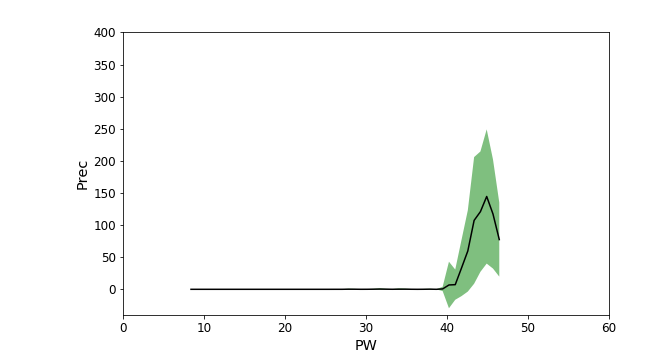

interactive(children=(IntSlider(value=0, description='Time', max=99), Output()), _dom_classes=('widget-interac…

In [14]:
%matplotlib nbagg
print("showing conditional distribution of 2D variable")

fig,ax = plt.subplots(figsize=(9,5))

def show(i_t):
    
    d = cond_dist_2D.cond_distributions[i_t]
    plt.cla()
    # plot mean
    ax.plot(d.on.percentiles,d.cond_mean,'k')
    # plot 1-sigma standard error
    x = d.on.percentiles
    y1 = d.cond_mean - np.sqrt(d.cond_var)
    y2 = d.cond_mean + np.sqrt(d.cond_var)
    m = np.logical_not(np.logical_or(np.isnan(x),np.isnan(d.cond_var)))
    x = x[m]
    y1 = y1[m]
    y2 = y2[m]
    print(m.sum())
    ax.fill_between(x,y1,y2,where=y2>=y1,facecolor='g',alpha=0.5,interpolate=True)

    ax.set_xlabel(ref_varid)
    ax.set_ylabel(cond_varid_2D)
    ax.set_xlim((0,60))
    ax.set_ylim((-40,400))

    plt.show()
    

i_t = widgets.IntSlider(min=0,max=99,step=1,value=0,description='Time')

interact(show,i_t=i_t);

In [13]:
print("compute conditional distribution for a 3D variable")
# cond_varid_3D = 'W'
cond_varid_3D = 'QRAD'
data = ds_3D[cond_varid_3D].values
# Initialize
cond_dist_3D = ConditionalDistributionOverTime(name=cond_varid_3D,
                                               time=time,
                                               is3D=True,
                                               on=ref_dist_linear)
# Compute conditional distributions
cond_dist_3D.computeConditionalStatsOverTime(data)


compute conditional distribution for a 3D variable


showing conditional distribution of 2D variable


<IPython.core.display.Javascript object>


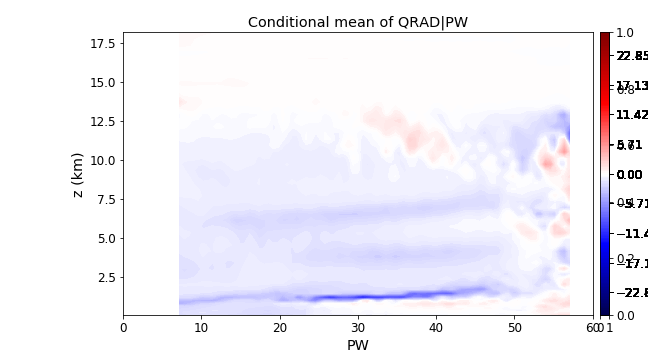

interactive(children=(IntSlider(value=10, description='Time', max=99, min=10), Output()), _dom_classes=('widge…

In [21]:
%matplotlib nbagg

print("showing conditional distribution of 2D variable")

fig,ax = plt.subplots(figsize=(9,5))
i_tmin = 10

# min-max values of conditional mean
mins = [np.nanmin(cond_dist_3D.cond_distributions[i_t].cond_mean) for i_t in range(nt)]
maxs = [np.nanmax(cond_dist_3D.cond_distributions[i_t].cond_mean) for i_t in range(nt)]
vmax = max(abs(np.max(maxs)),abs(np.min(mins)))
vmin = -vmax

def show(i_t = i_tmin):
    
    # Clear plot between each display
    ax.cla()

    d = cond_dist_3D.cond_distributions[i_t]
    ## Data
    x = d.on.percentiles
    y = ds_3D.z/1000
    # mean
    Z = d.cond_mean
    # err
    Z_err = np.absolute(d.cond_mean)/d.cond_std

    ## Plot
    h = subplotSmooth2D(ax,x,\
                      y,\
                      Z,\
                   fplot='contourf',\
                   vmin=vmin,vmax=vmax,nlev=200,\
                   xmin=0,xmax=60,nx=100,\
                   cmap = plt.cm.seismic)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='2%', pad=0.1)
    cbar1 = fig.colorbar(h, cax=cax, orientation='vertical')

    ax.set_xlabel(ref_varid)
    ax.set_ylabel('z (km)')

    ax.set_title('Conditional mean of %s|%s'%(cond_varid_3D,ref_varid))

    plt.show()
    

i_t = widgets.IntSlider(min=i_tmin,max=nt-1,step=1,value=0,description='Time')

interact(show,i_t=i_t);

showing conditional distribution of 2D variable


<IPython.core.display.Javascript object>


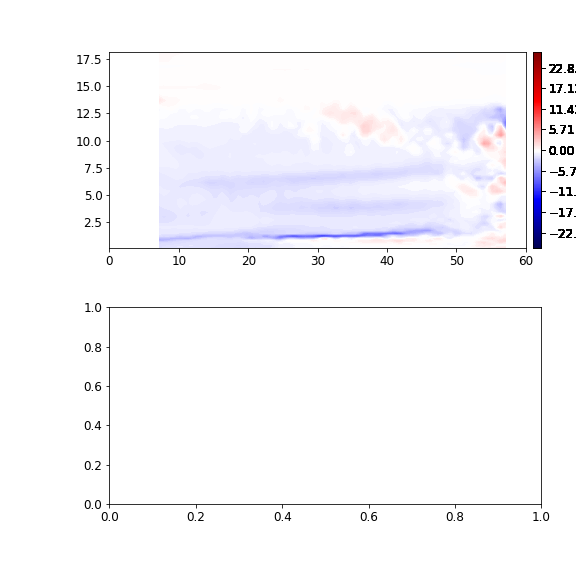

/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


interactive(children=(IntSlider(value=10, description='Time', max=99, min=10), Output()), _dom_classes=('widge…

In [17]:
%matplotlib nbagg

print("showing conditional distribution of 2D variable")

fig,axs = plt.subplots(nrows=2,figsize=(8,8))
i_tmin = 10

# min-max values of conditional mean
mins = [np.nanmin(cond_dist_3D.cond_distributions[i_t].cond_mean) for i_t in range(nt)]
maxs = [np.nanmax(cond_dist_3D.cond_distributions[i_t].cond_mean) for i_t in range(nt)]
vmax = max(abs(np.max(maxs)),abs(np.min(mins)))
vmin = -vmax
# max value of relative error
mins = [np.nanmin(np.absolute(d.cond_mean)/d.cond_std) for d in cond_dist_3D.cond_distributions]
maxs = [np.nanmax(np.absolute(d.cond_mean)/d.cond_std) for d in cond_dist_3D.cond_distributions]
vmax_err = max(abs(np.max(maxs)),abs(np.min(mins)))
vmin_err = 0
norm_err = MidpointNormalize(midpoint=1,vmin=vmin_err,vmax=vmax_err)

def show(i_t = i_tmin):
    
    # Clear plot between each display
    axs[0].cla()

    d = cond_dist_3D.cond_distributions[i_t]
    ## Data
    x = d.on.percentiles
    y = ds_3D.z/1000
    # mean
    Z = d.cond_mean
    # err
    Z_err = np.absolute(d.cond_mean)/d.cond_std

    ## Plot
    h = subplotSmooth2D(axs[0],x,\
                      y,\
                      Z,\
                   fplot='contourf',\
                   vmin=vmin,vmax=vmax,nlev=200,\
                   xmin=0,xmax=60,nx=100,\
                   cmap = plt.cm.seismic)

    divider = make_axes_locatable(axs[0])
    cax = divider.append_axes('right', size='2%', pad=0.1)
    cbar1 = fig.colorbar(h, cax=cax, orientation='vertical')

    h = subplotSmooth2D(axs[1],x,\
                      y,\
                      Z_err,\
                   fplot='contourf',\
    #                xmin=10,xmax=40,nx=100,\
                   vmin=vmin_err,vmax=vmax_err,nlev=200,\
                   cmap = plt.cm.RdYlGn,\
                   norm=norm_err)

    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes('right', size='2%', pad=0.1)
    cbar2 = fig.colorbar(h, cax=cax, orientation='vertical')

    for ax in axs:
        ax.set_xlabel(ref_varid)
        ax.set_ylabel('z (km)')

    axs[0].set_title('Conditional mean of %s|%s'%(cond_varid_3D,ref_varid))
    axs[1].set_title('Conditional error of %s|%s'%(cond_varid_3D,ref_varid))

    plt.show()
    

i_t = widgets.IntSlider(min=i_tmin,max=nt-1,step=1,value=0,description='Time')

interact(show,i_t=i_t);